#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16517, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 16517 (delta 47), reused 50 (delta 16), pack-reused 16402
Receiving objects: 100% (16517/16517), 15.18 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (11307/11307), done.
/kaggle/working/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.2 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16276MB, multi_processor_count=56)


## Step 6: Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="l3ZRwINmzPuMzyjtYwHf")
project = rf.workspace("md-hasibul-islam-dhrubo").project("pavement-damage-detection-3")
version = project.version(3)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    


Extracting Dataset Version Zip to Pavement-damage-detection--3-3 in yolov5pytorch:: 100%|██████████| 7782/7782 [00:01<00:00, 4535.54it/s]


In [4]:
%pwd

'/kaggle/working/yolov5'

In [5]:
dataset.location

'/kaggle/working/yolov5/Pavement-damage-detection--3-3'

In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Crack
- Edgecrack
- pothole
nc: 3
roboflow:
  license: CC BY 4.0
  project: pavement-damage-detection-3
  url: https://universe.roboflow.com/md-hasibul-islam-dhrubo/pavement-damage-detection-3/dataset/3
  version: 3
  workspace: md-hasibul-islam-dhrubo
test: ../test/images
train: Pavement-damage-detection--3-3/train/images
val: Pavement-damage-detection--3-3/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
num_classes

'3'

In [9]:
#this is the model configuration we will use for our tutorial
%cat /kaggle/working/yolov5/models/segment/yolov5m-seg.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Segment, [nc, anchors, 32, 256]], # Detect(P3, P4, P5)
  ]

In [12]:
%cat /kaggle/working/yolov5/models/custom_yolov5.yaml


# parameters
nc: 3  # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [13]:
# train yolov5s on custom data for 200 epochs
# time its performance
#%%time
%cd /kaggle/working/yolov5/
!python segment/train.py --img 640 --batch 16 --epochs 300 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5.yaml --weights 'yolov5m-seg.pt' --name yolov5_results  --cache

/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-03-23 15:52:09.590392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:52:09.590525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 15:52:09.728169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due t

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

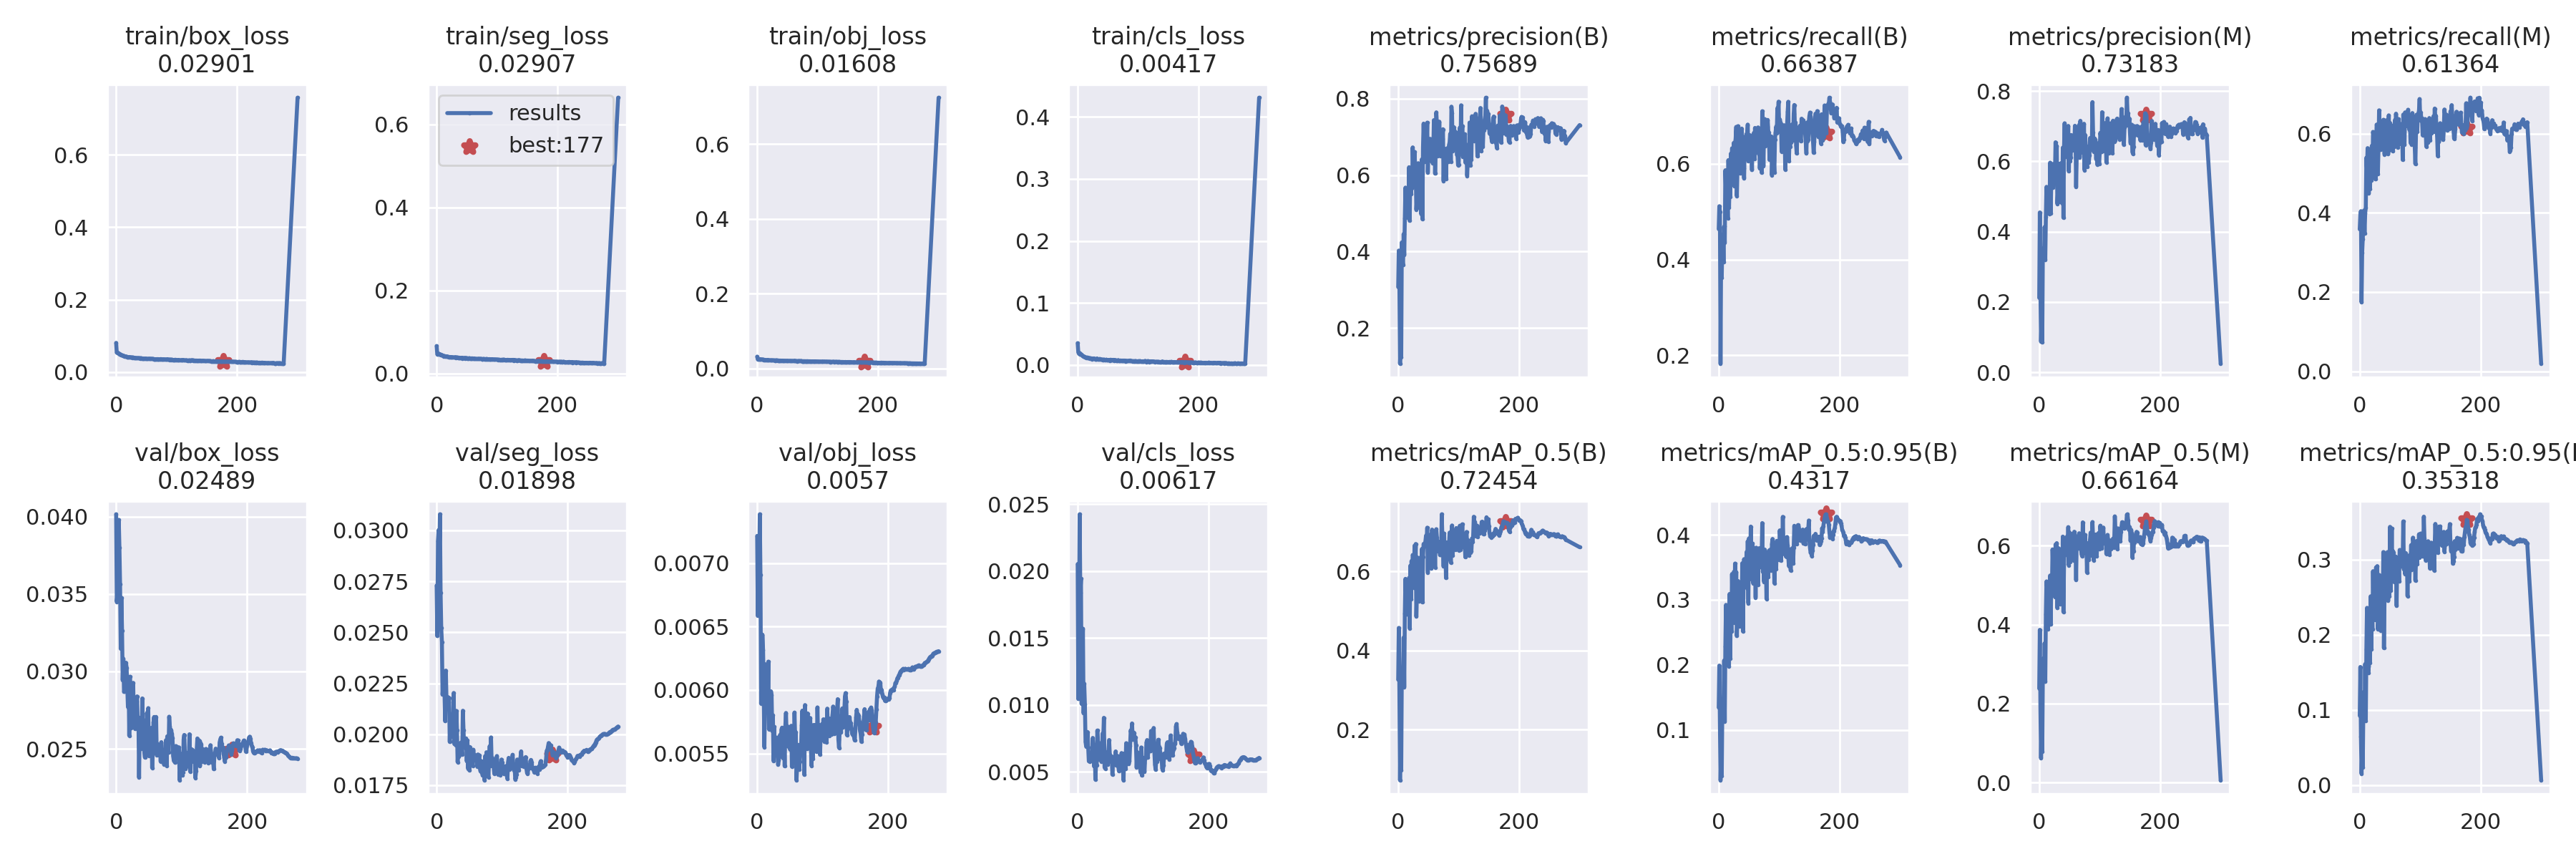

In [14]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/kaggle/working/yolov5/runs/train-seg/yolov5_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

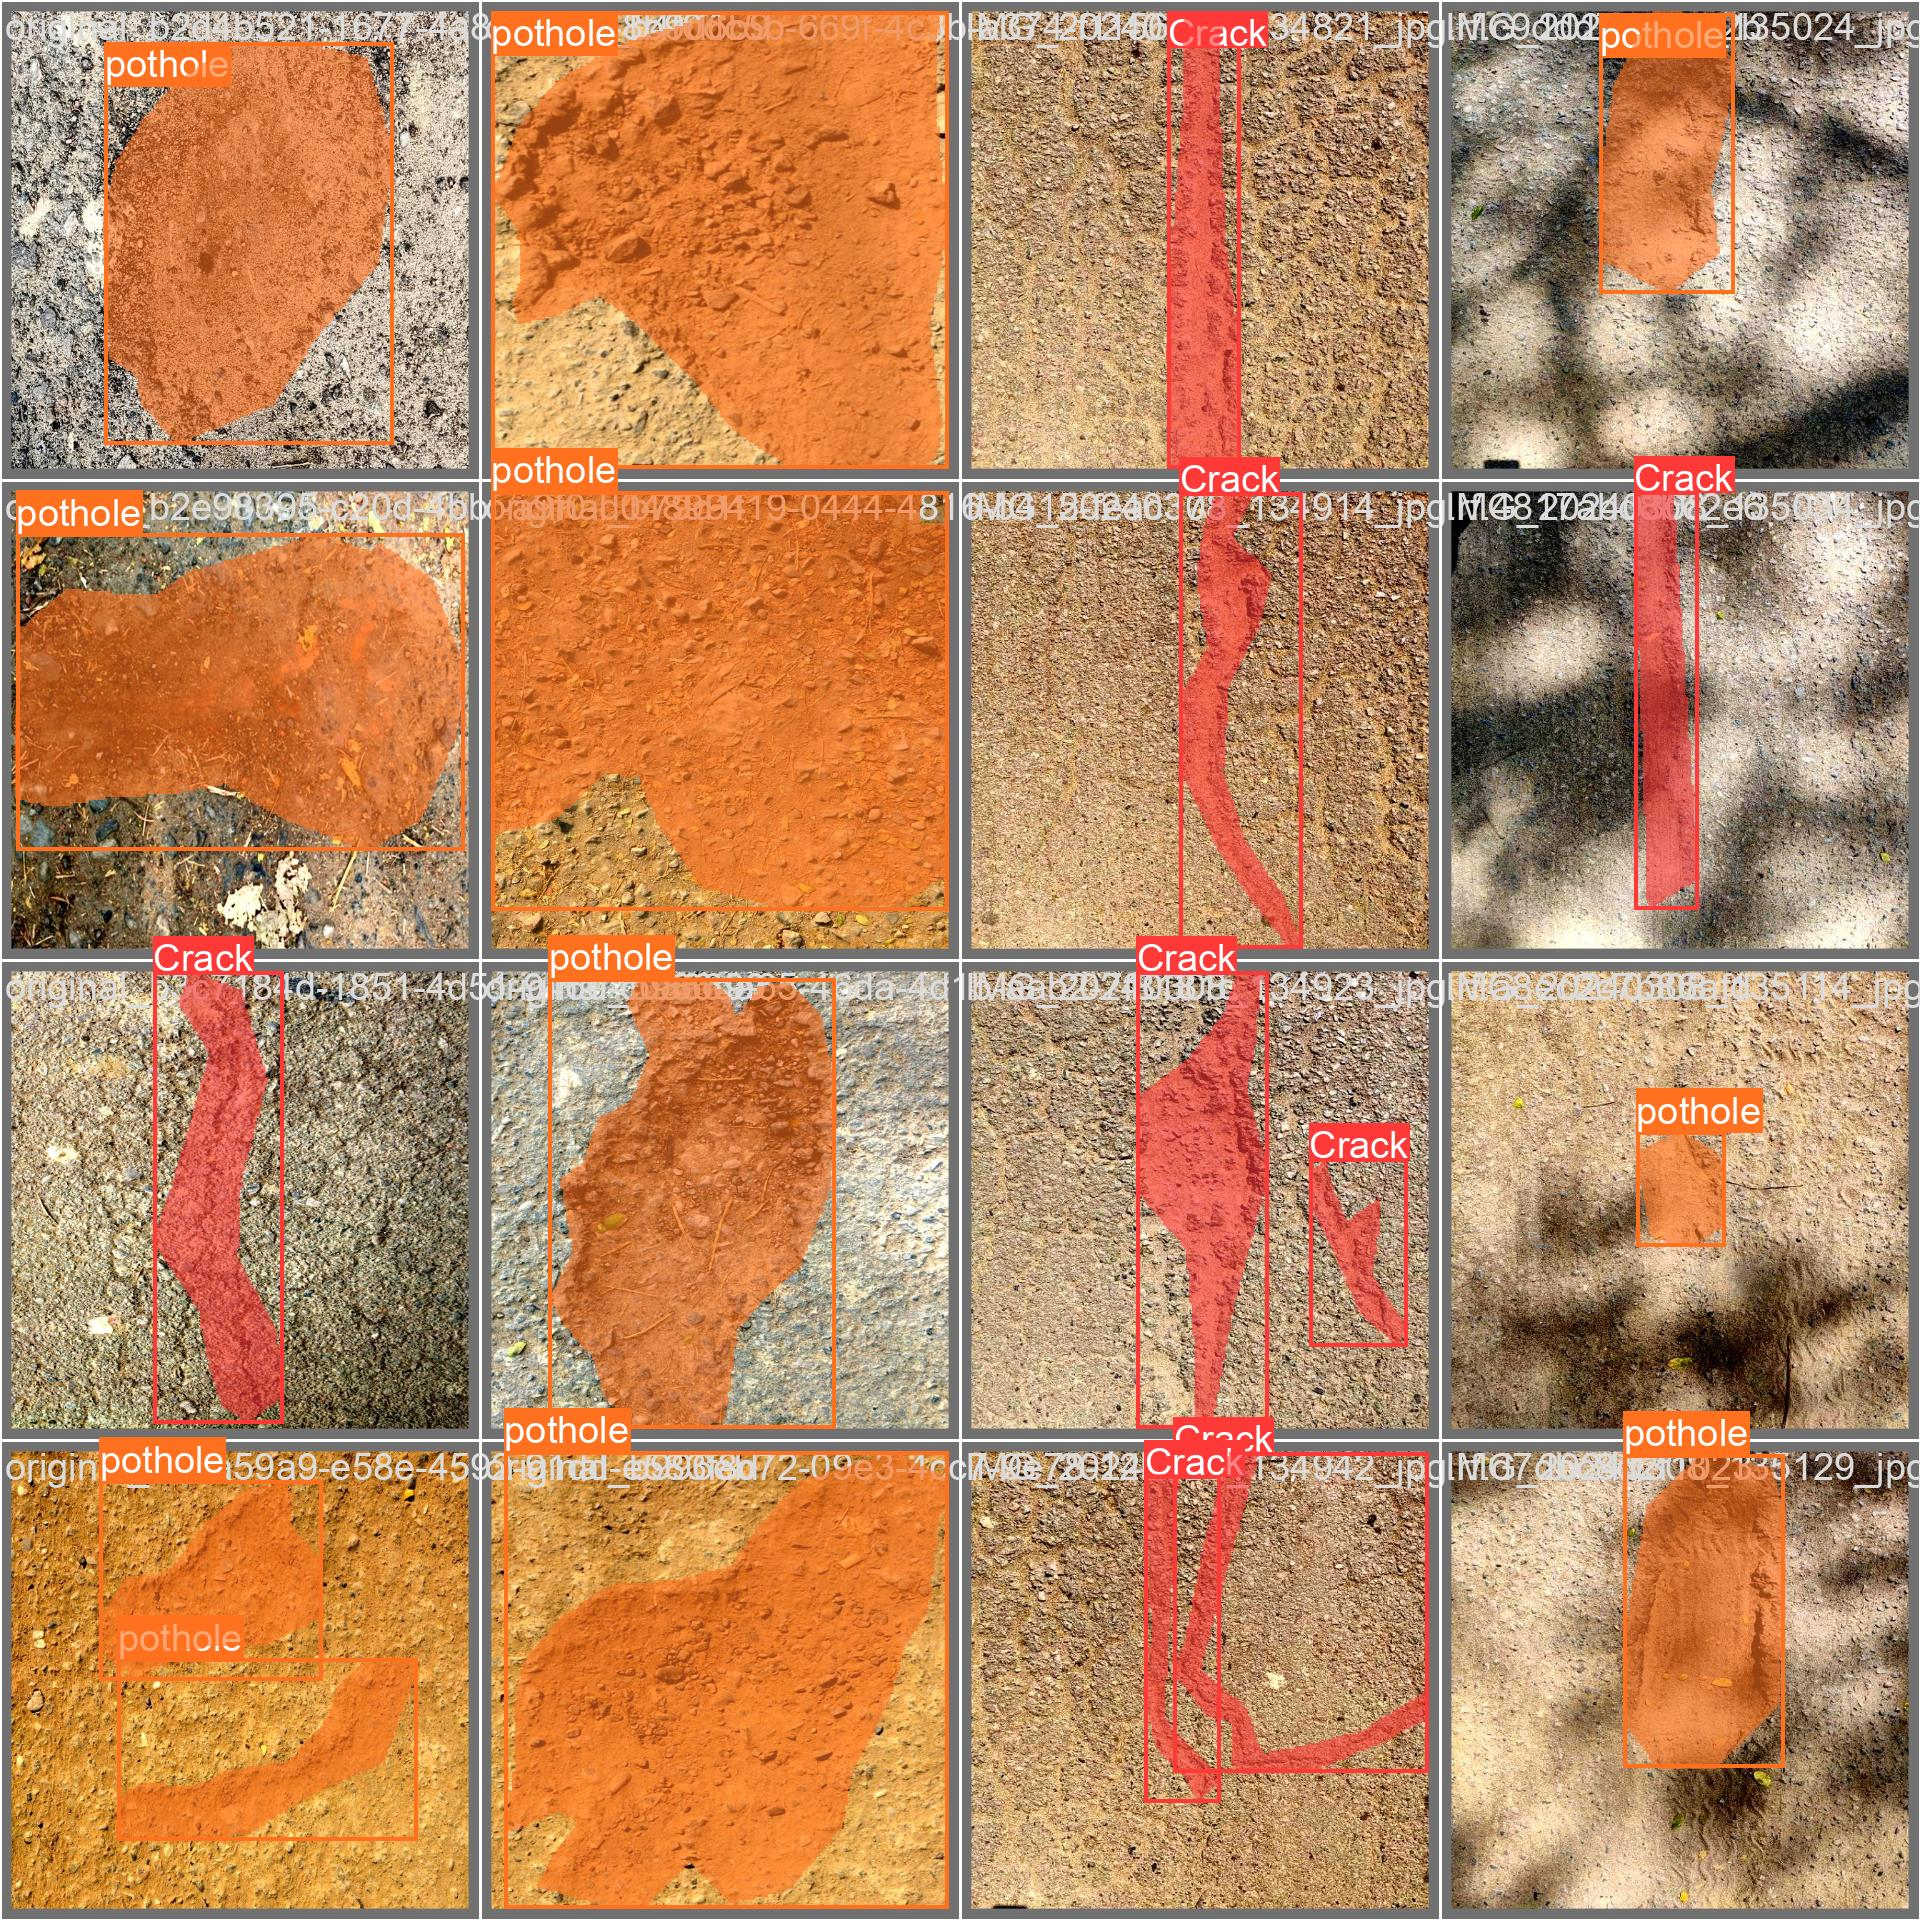

In [15]:
Image(filename='/kaggle/working/yolov5/runs/train-seg/yolov5_results/val_batch0_labels.jpg', width=800)

GROUND TRUTH AUGMENTED TRAINING DATA:


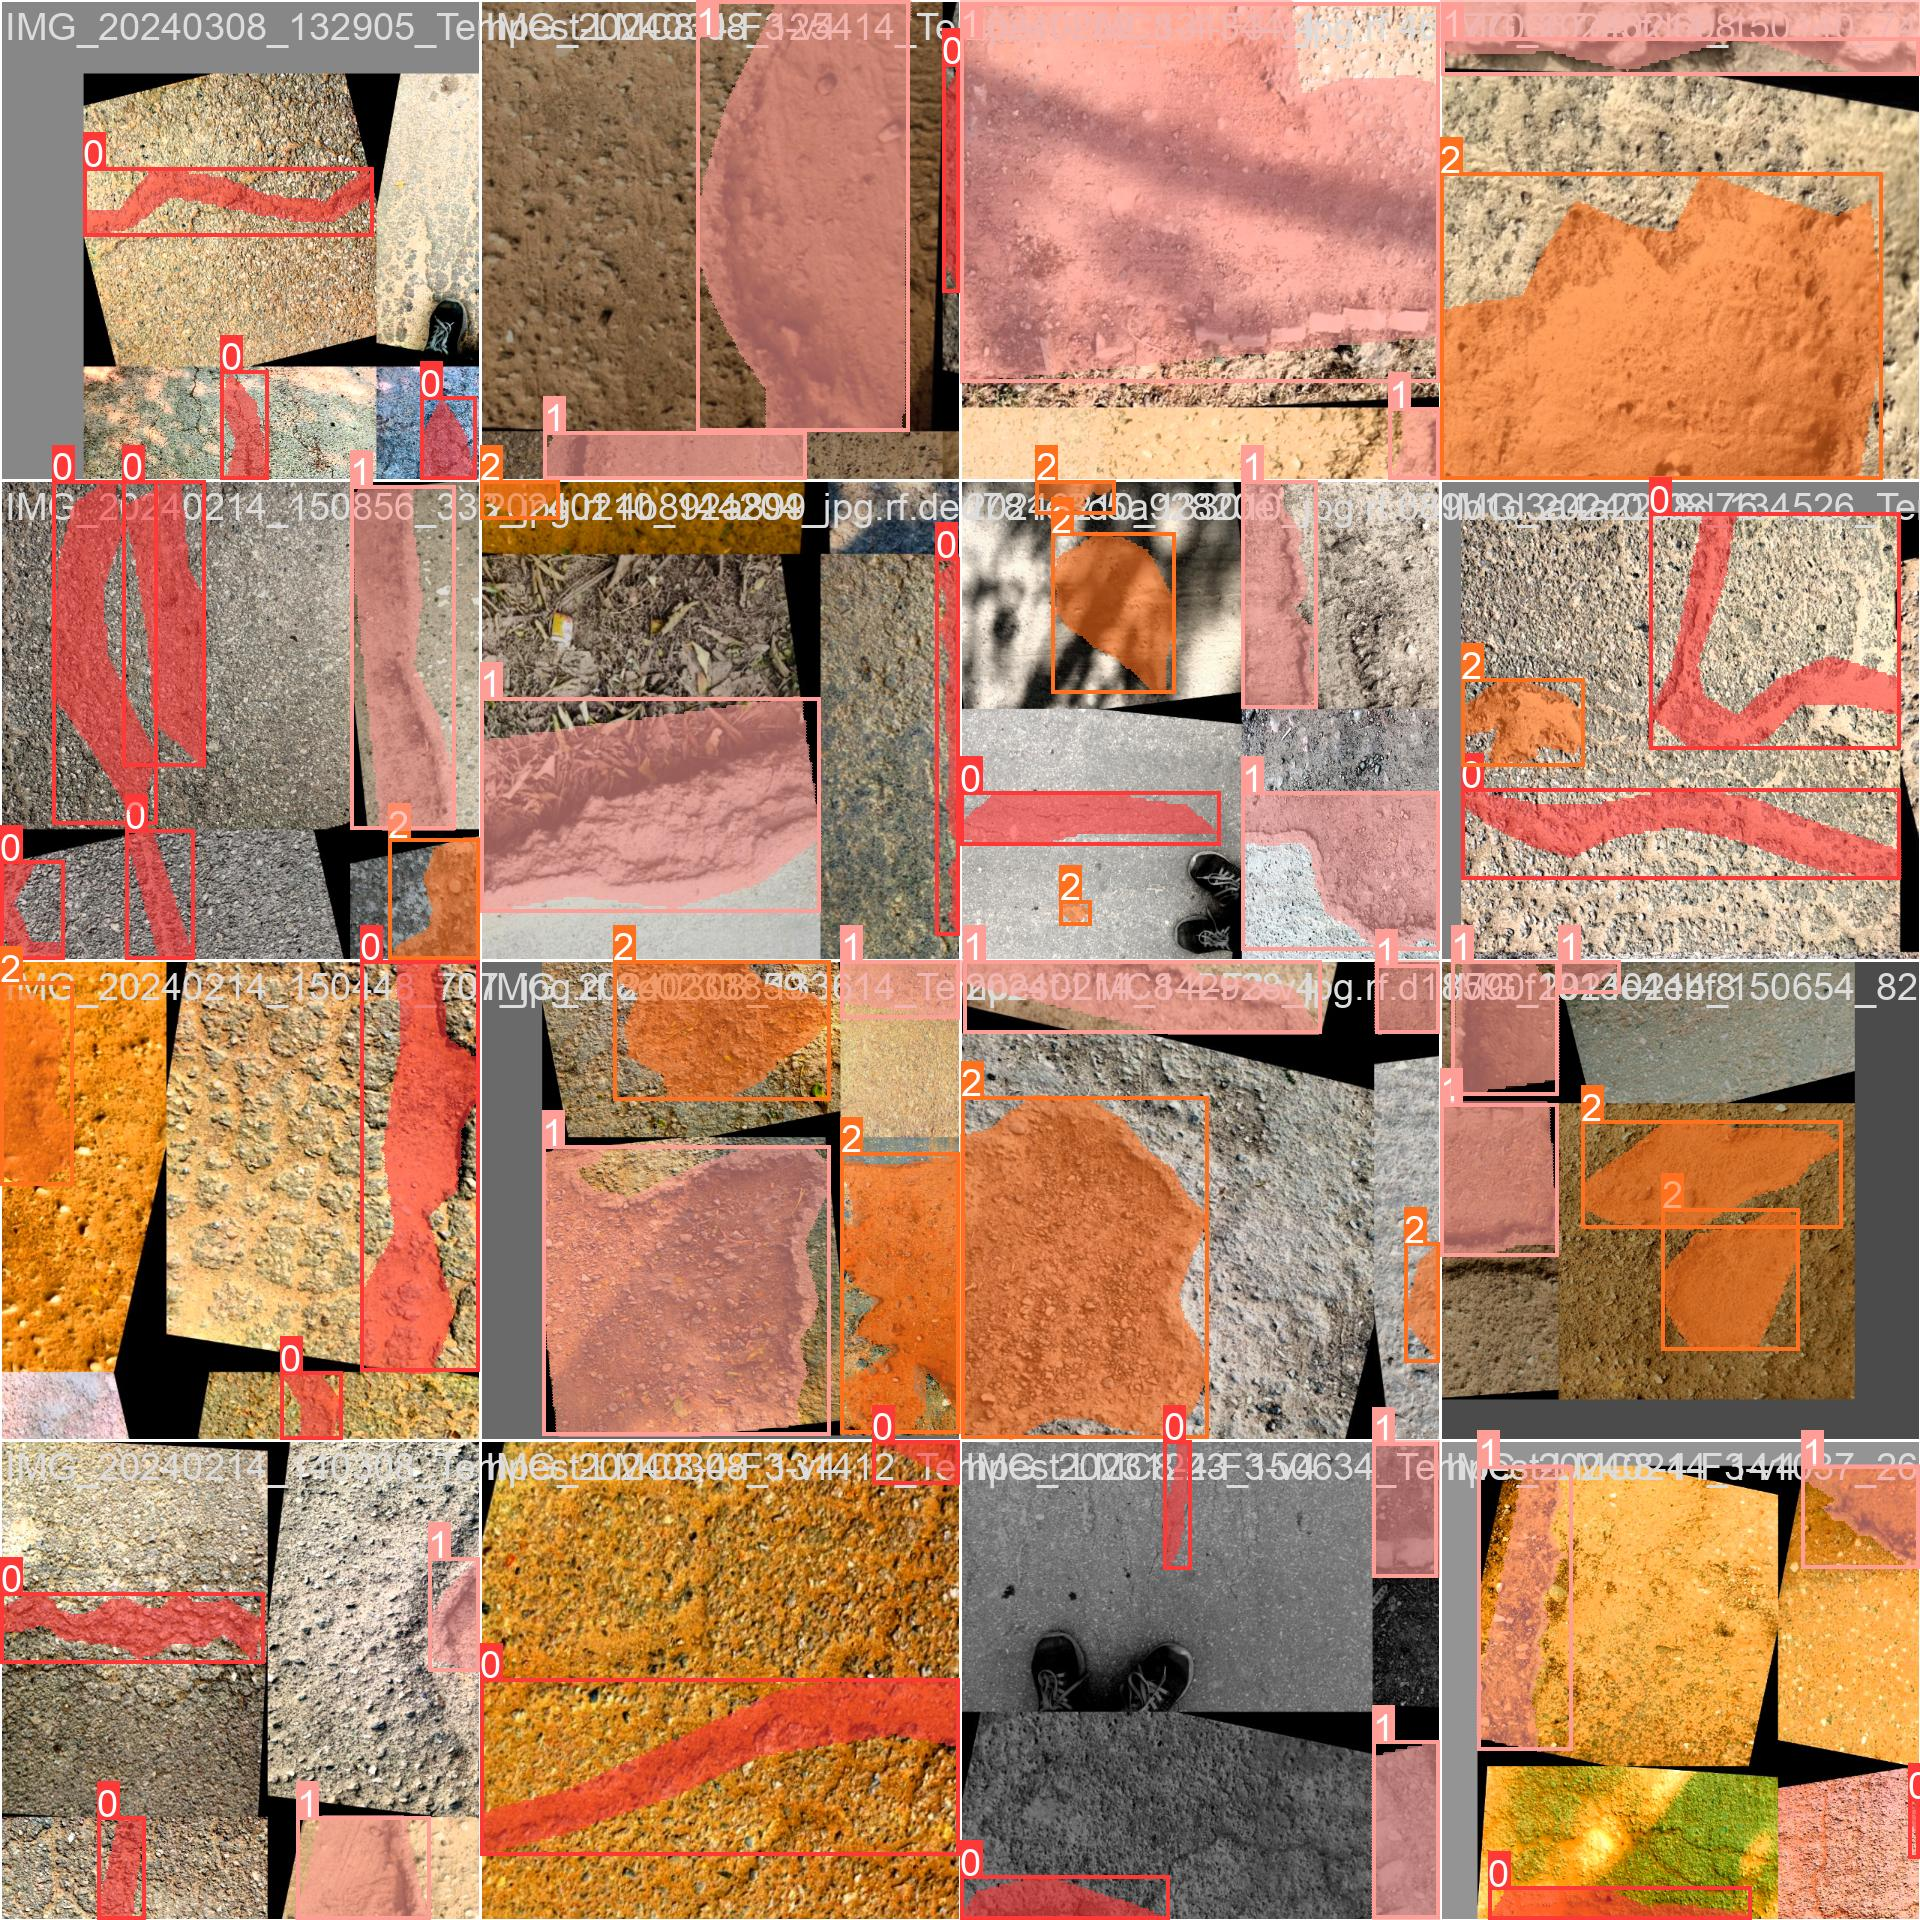

In [16]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/kaggle/working/yolov5/runs/train-seg/yolov5_results/train_batch0.jpg', width=700)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [17]:
# trained weights are saved by default in our weights folder
%ls runs/

train-seg/


In [18]:
%ls runs/train-seg/yolov5_results/weights

best.pt  last.pt


In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [19]:
%cd /kaggle/working/yolov5/
!python segment/predict.py --weights /kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.pt --img 640 --conf 0.3 --source {dataset.location}/test/images

/kaggle/working/yolov5
segment/predict: weights=['/kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.pt'], source=/kaggle/working/yolov5/Pavement-damage-detection--3-3/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
custom_YOLOv5 summary: 220 layers, 21660440 parameters, 0 gradients, 69.9 GFLOPs
image 1/100 /kaggle/working/yolov5/Pavement-damage-detection--3-3/test/images/IMG_20240308_132239_jpg.rf.699a6fa0ff1a77fa53e5ade3e00bf6a3.jpg: 640x640 2 Cracks, 14.6ms
image 2/100 /kaggle/wo

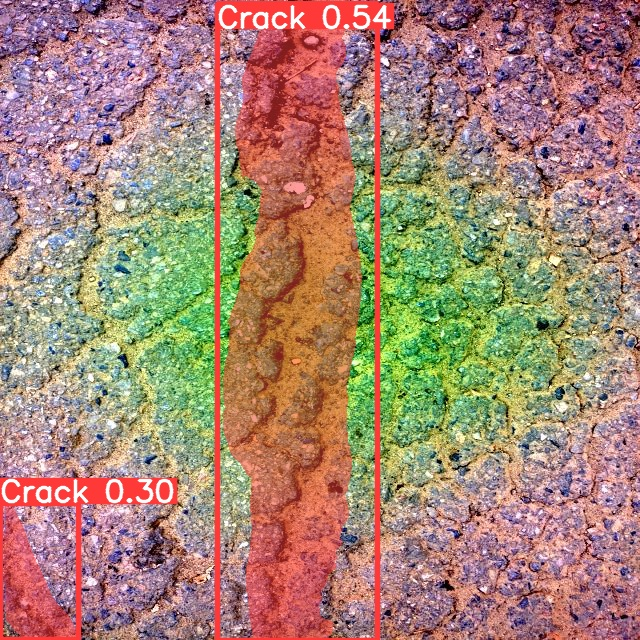

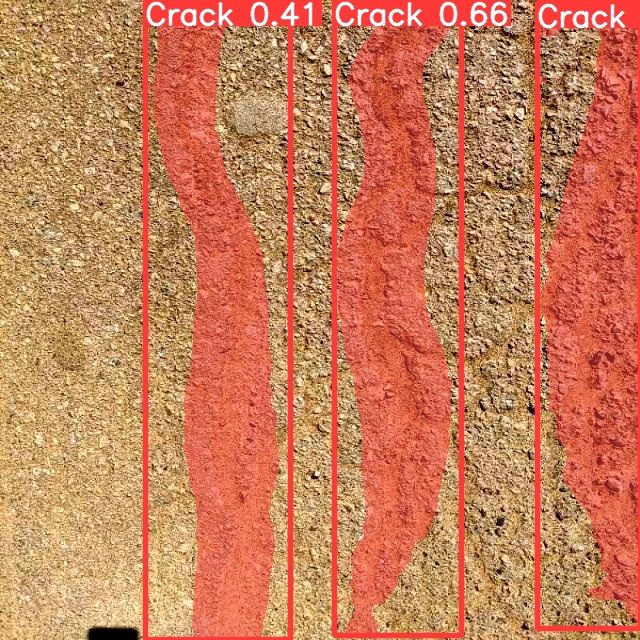

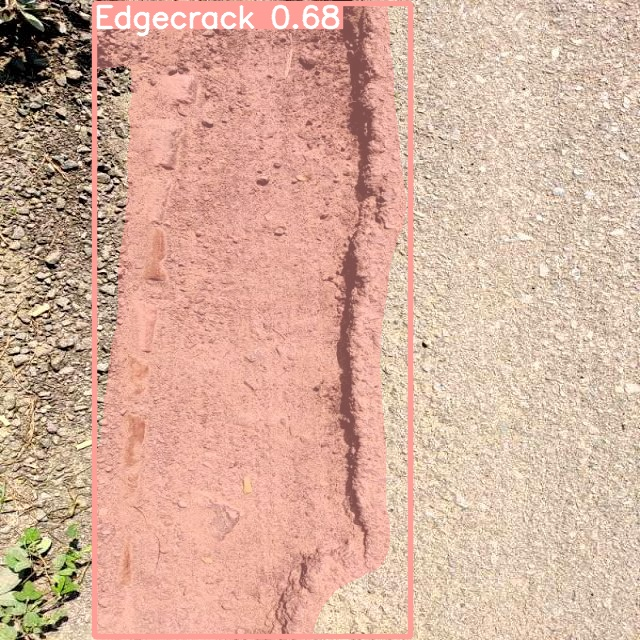

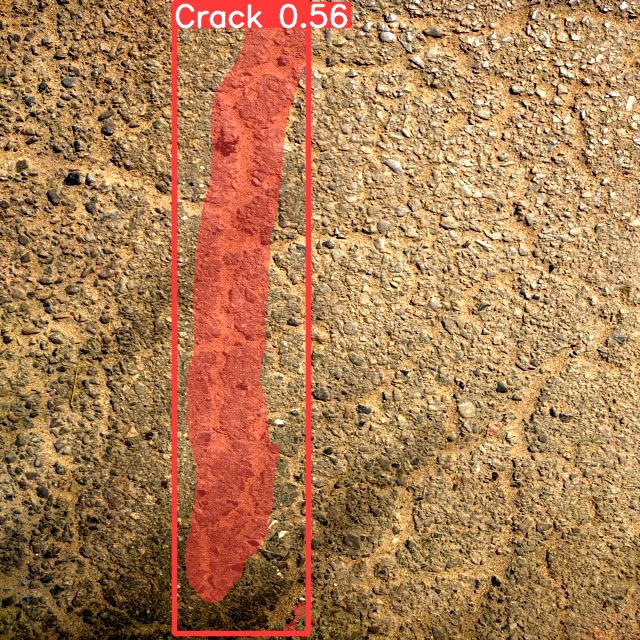

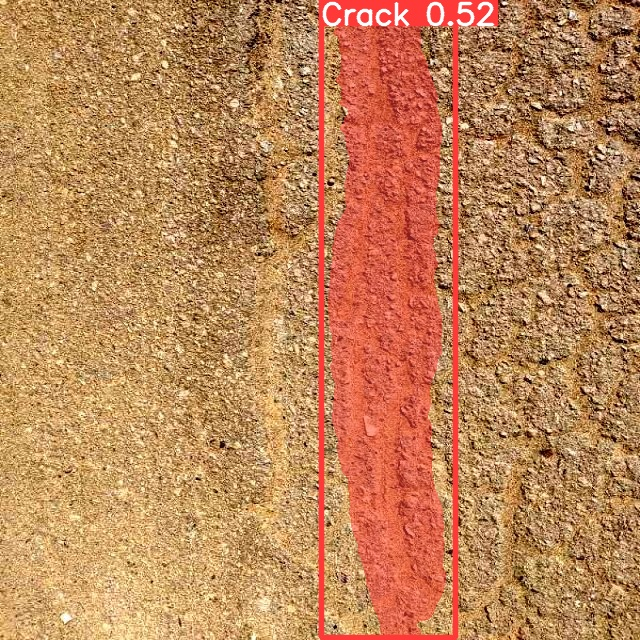

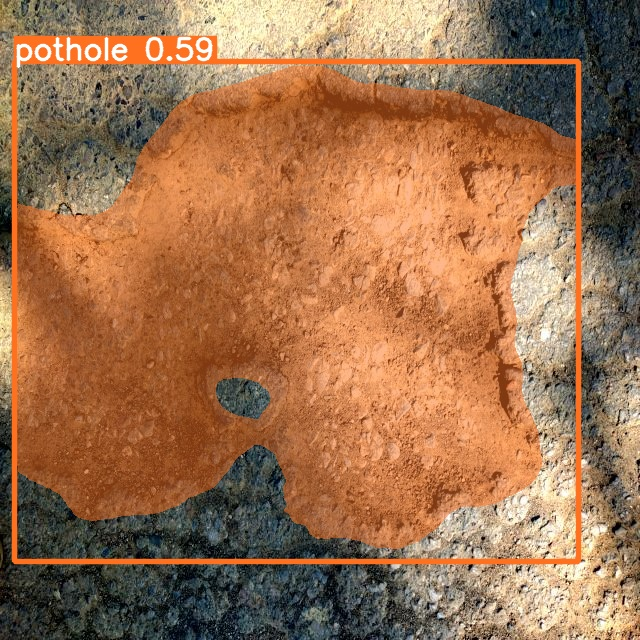

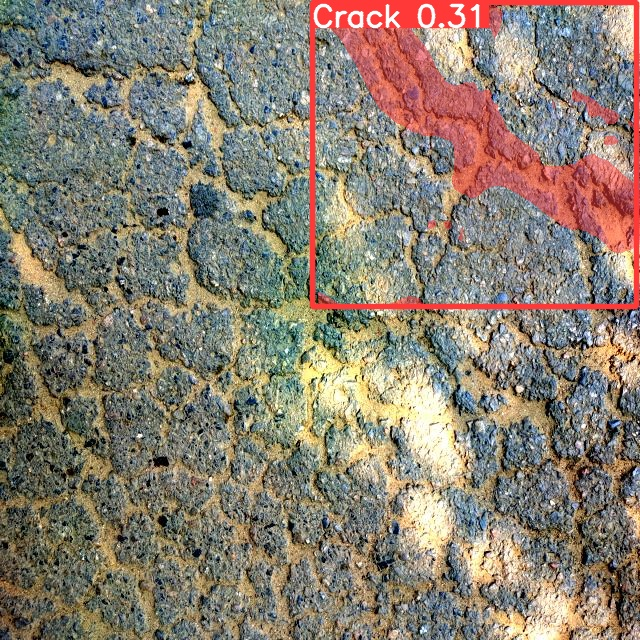

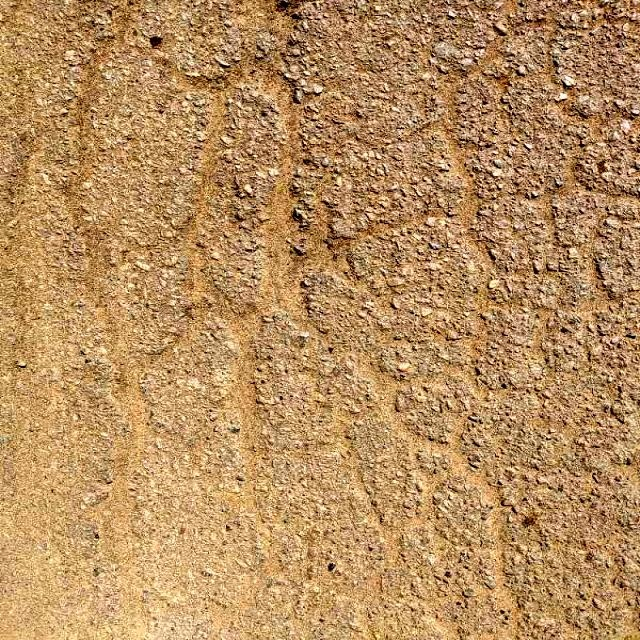

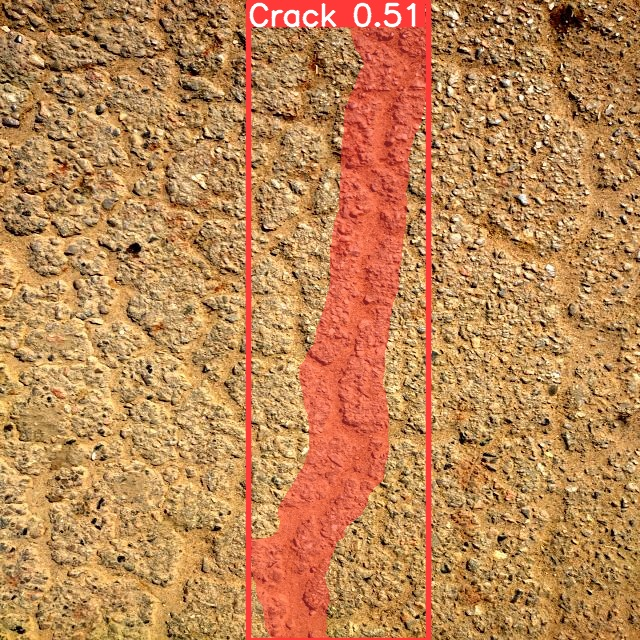

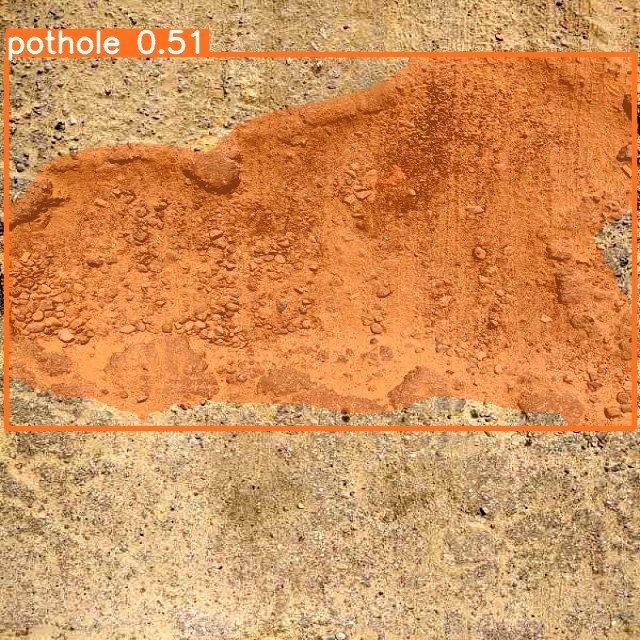

In [20]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/kaggle/working/yolov5/runs/predict-seg/exp/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [21]:
!python export.py --weights /kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.pt --include torchscript onnx

export: data=data/coco128.yaml, weights=['/kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.13 torch-2.1.2 CPU

Fusing layers... 
custom_YOLOv5 summary: 220 layers, 21660440 parameters, 0 gradients, 69.9 GFLOPs

PyTorch: starting from /kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.pt with output shape (1, 25200, 40) (41.8 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 4.6s, saved as /kaggle/working/yolov5/runs/train-seg/yolov5_results/weights/best.torchscript (83.2 MB)

ONNX: starting export with onnx 1.15.0...
ONNX: export success ✅ 2.5s, saved a